# Finetuning and evaluation of LLMs on functional representation tasks
This notebook demonstrates an interactive development approach when finetuning a large language model (LLM) for a functional representation task.


## Usecase
Functional representation can be extremely helpful in the context of categorizing and understanding the meaning of natural language prompts. It can be used to help automatically categorize products given a description for e-commerce, or to help categorize and understand the meaning of user queries in a chatbot for a customer service application. In this notebook, we will be using functional representation to categorize natural language prompts in the video game domain.


## Data
For the purposes of finetuning, it is crucial to have a dataset that contains representative examples of the task we are trying to solve. In this notebook, we will be using a readily available dataset for the task of functional representation. More specifically, we will use the [VIGGO Dataset](https://huggingface.co/datasets/GEM/viggo) which is a collection of natural language prompts and their corresponding meaning representations in the video game domain. 

**Example Data Record**

- Input: "What is it about games released in 2005 that makes you think it's such a fantastic year for video games?"
- Output: request_explanation(release_year[2005], rating[excellent])

Note for our task, we technically used the VIGGO Dataset in an "inverted" fashion to its original data-to-text intent, taking in as input a natural language prompt and producing as output a meaning representation.


## Model
We require using a small model for this task to reduce the computational cost. More specificaly, we will be attempting to finetuning a Mistral 7B parameter model for this task.

## Tech stack
- Anyscale's `llm-forge` which provides a high-level abstraction to running distributed training jobs on Ray.
- Anyscale's `ray-llm` which provides a high-level abstraction to deploying vLLM based models on Ray.

## Why finetune?
We establish the need to finetune a model for this task because of one or more of the following reasons:
- The quality of readily available similar sized models is not sufficient after benchmarking.
- The cost of performing a very large few-shot learning task is too high compared to the amortized cost of finetuning.
- Data privacy and security concerns on sending the data to a closed-source model.


## Roadmap
Here is a high-level overview of the steps we will be following in this notebook:

1. Setup
2. Prepare and Understand our Data
3. Establish a baseline performance evaluation
4. Finetune an LLM
5. Evaluate the finetuned LLM

## 1. Setup

We start off by importing the necessary libraries and defining some types and constants.

### Imports

In [2]:
import os
import ray
import time
import shutil
from pprint import pprint
from uuid import uuid4
from typing import cast, Optional, Literal

import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import re
import yaml
from anyscale.service.models import ServiceState
from anyscale.service import deploy, status
from anyscale.service.models import ServiceConfig
from openai.resources.chat.completions import ChatCompletionMessageParam

### Types

In [3]:
SystemMessageT = ChatCompletionMessageParam
UserMessageT = ChatCompletionMessageParam
AssistantMessageT = ChatCompletionMessageParam
RolesT = Literal["system", "user", "assistant"]

### Constants

In [4]:
ROLES = ["system", "user", "assistant"]
LLM_MODEL = "mistralai/Mistral-7B-Instruct-v0.1"
HUGGING_FACE_HUB_TOKEN = os.environ["HUGGING_FACE_HUB_TOKEN"]
ARTIFACT_STORAGE_PATH = os.environ["ANYSCALE_ARTIFACT_STORAGE"].rstrip("/") + "/"
MODEL_STORAGE_PATH = f"{ARTIFACT_STORAGE_PATH}lora_finetuning/dev/"
SYSTEM_PROMPT = (
    "Given a target sentence construct the underlying meaning "
    "representation\n"
    "of the input sentence as a single function with attributes and "
    "attribute\n"
    "values. This function should describe the target string "
    "accurately and the\n"
    "function must be one of the following ['inform', 'request', "
    "'give_opinion',\n"
    "'confirm', 'verify_attribute', 'suggest', 'request_explanation',\n"
    "'recommend', 'request_attribute'].\n"
    "\n"
    "The attributes must be one of the following:\n"
    "['name', 'exp_release_date', 'release_year', 'developer', 'esrb', "
    "'rating',\n"
    "'genres', 'player_perspective', 'has_multiplayer', 'platforms',\n"
    "'available_on_steam', 'has_linux_release', 'has_mac_release', "
    "'specifier']\n"
)

## 1. Preparing and Understanding our Data

We will first start out by preparing and understanding our dataset. 

This is arguably the most important step in the process of developing a finetuning pipeline. To do this, we will:

1. Read our version of the VIGGO dataset
2. Inspect sample prompts
3. Run data checks
4. Visualize distributions

### 1. Read our version of the VIGGO dataset

We have split our dataset into training, validation and test. A validation dataset is used to stop training when the model starts to overfit. The test dataset is used to evaluate the model's performance on unseen data. Note the training dataset exists as various subsets of the original dataset to enable the retraining on increasing amounts of data.

In [5]:
data_paths = {
    "train": "s3://anyscale-public-materials/llm-finetuning/viggo_inverted/train/subset-200.jsonl",
    "test": "s3://anyscale-public-materials/llm-finetuning/viggo_inverted/test/data.jsonl",
    "validation": "s3://anyscale-public-materials/llm-finetuning/viggo_inverted/valid/data.jsonl",
}

We read in the data into memory. In the case the data was too large to fit, we would have used of ray data's sampling or limiting capabilities to read in a subset of the data for our exploratory data analysis.

In [6]:
dfs = {
    dataset: ray.data.read_json(data_path).to_pandas()
    for dataset, data_path in data_paths.items()
}

2024-06-06 03:43:56,650	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 100.126.238.119:6379...
2024-06-06 03:43:56,656	INFO worker.py:1743 -- Connected to Ray cluster. View the dashboard at https://session-rfxv1j89kxdnwm8svbi9w6xla6.i.anyscaleuserdata.com 
2024-06-06 03:43:56,678	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_0b494aeef520ff0a5b69422cf8afd482a1016bf4.zip' (8.47MiB) to Ray cluster...
2024-06-06 03:43:56,710	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_0b494aeef520ff0a5b69422cf8afd482a1016bf4.zip'.


(autoscaler +10s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +10s) [autoscaler] [8CPU-32GB] Upscaling 1 node(s).
(autoscaler +12s) [autoscaler] [8CPU-32GB|m5.2xlarge] [us-east-2b] [on-demand] Launched 1 instances.


(MapBatches(exclude_failed_responses) pid=7351, ip=100.74.253.34) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'model_failure', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapBatches(exclude_failed_responses) pid=7351, ip=100.74.253.34) - Expand out each key-value pair in the dict column into its own column
(MapBatches(exclude_failed_responses) pid=7351, ip=100.74.253.34) - Replace `None` values with an Arrow supported data type
(MapBatches(exclude_failed_responses) pid=7351, ip=100.74.253.34) 


(autoscaler +2m1s) [autoscaler] Cluster upscaled to {32 CPU, 0 GPU}.


We check on the dataset sizes

In [7]:
for split, df in dfs.items():
    print(f"{split=}, size={df.shape[0]}")

split='train', size=200
split='test', size=400
split='validation', size=100


### 2. Inspect sample prompts

It is important to understand the structure of your data before you start working with it. We first verify that the data is in the correct format that `llm-forge` expects which is a single-turn openai formate - i.e. were each message is a single turn in the conversation of system, user and assistant messages.

In [8]:
dfs["train"].head()

,messages
0,"[{'role': 'system', 'content': 'Given a target..."
1,"[{'role': 'system', 'content': 'Given a target..."
2,"[{'role': 'system', 'content': 'Given a target..."
3,"[{'role': 'system', 'content': 'Given a target..."
4,"[{'role': 'system', 'content': 'Given a target..."


In [9]:
for df in dfs.values():
    assert df["messages"].apply(len).drop_duplicates().item() == 3

We then extract some sample conversations from the training data.

In [10]:
system0, user0, assistant0 = dfs["train"].iloc[0].item()
system1, user1, assistant1 = dfs["train"].iloc[1].item()
system2, user2, assistant2 = dfs["train"].iloc[2].item()

Here is the system prompt. It contains the instructions on the functional representation task enumerating the accepted function and attribute types to extract

In [11]:
pprint(system0)

{'content': 'Given a target sentence construct the underlying meaning '
            'representation\n'
            'of the input sentence as a single function with attributes and '
            'attribute\n'
            'values. This function should describe the target string '
            'accurately and the\n'
            "function must be one of the following ['inform', 'request', "
            "'give_opinion',\n"
            "'confirm', 'verify_attribute', 'suggest', 'request_explanation',\n"
            "'recommend', 'request_attribute'].\n"
            '\n'
            'The attributes must be one of the following:\n'
            "['name', 'exp_release_date', 'release_year', 'developer', 'esrb', "
            "'rating',\n"
            "'genres', 'player_perspective', 'has_multiplayer', 'platforms',\n"
            "'available_on_steam', 'has_linux_release', 'has_mac_release', "
            "'specifier']\n",
 'role': 'system'}


Here is the user prompt it contains a target sentence that we want to extract.

In [12]:
pprint(user0)

{'content': 'Here is the target sentence:\n'
            'Dirt: Showdown from 2012 is a sport racing game for the '
            'PlayStation, Xbox, PC rated E 10+ (for Everyone 10 and Older). '
            "It's not available on Steam, Linux, or Mac.",
 'role': 'user'}


Here is the expected assistant meaning representation:

In [13]:
pprint(assistant0)

{'content': 'inform(name[Dirt: Showdown], release_year[2012], esrb[E 10+ (for '
            'Everyone 10 and Older)], genres[driving/racing, sport], '
            'platforms[PlayStation, Xbox, PC], available_on_steam[no], '
            'has_linux_release[no], has_mac_release[no])',
 'role': 'assistant'}


### 3. Run data checks

We first extract the system, user and assitant messages from the dataset. We then run some basic data checks to ensure that the data is clean and ready for processing.

In [14]:
def extract_role(
    messages: tuple[
        SystemMessageT,
        UserMessageT,
        AssistantMessageT,
    ],
    role: Literal["system", "user", "assistant"],
) -> str:
    assert len(messages) == 3
    message = messages[ROLES.index(role)]
    assert message["role"] == role
    return cast(str, message["content"])

In [15]:
for df in dfs.values():
    df["system_message"] = df["messages"].apply(extract_role, role="system")
    df["user_message"] = df["messages"].apply(extract_role, role="user")
    df["assistant_message"] = df["messages"].apply(extract_role, role="assistant")

In [16]:
dfs["train"].head()

,messages,system_message,user_message,assistant_message
0,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown f...,"inform(name[Dirt: Showdown], release_year[2012..."
1,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012..."
2,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012..."
3,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nWere there even ...,"request(release_year[2014], specifier[terrible])"
4,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nWhat's the most ...,"request(release_year[2014], specifier[terrible])"


We check all system messages are the same across the splits.

In [17]:
for df in dfs.values():
    assert df["system_message"].nunique() == 1
    assert df["system_message"].unique()[0] == SYSTEM_PROMPT

We make sure all user prompts start with the statement "Here is the target sentence:\n"

In [18]:
for df in dfs.values():
    assert df["user_message"].str.startswith("Here is the target sentence:\n").all()

We extract the function types from the assistant messages.

In [19]:
def extract_function_type(response: Optional[str]) -> Optional[str]:
    """Extract the function type from the response."""
    if response is None:
        return None

    # pattern to match is "{function_type}({attributes})"
    expected_pattern = re.compile(r"^(?P<function_type>.+?)\((?P<attributes>.+)\)$")

    # remove any "Output: " prefix and strip the response
    match = expected_pattern.match(response.split("Output: ")[-1].strip())

    if match is None:
        return None

    # return the function type
    ret = match.group("function_type")
    return ret.replace("\\_", "_") # handle escapes of underscores

In [20]:
for df in dfs.values():
    df["function_type"] = df["assistant_message"].apply(extract_function_type)

In [21]:
dfs["train"].head()

,messages,system_message,user_message,assistant_message,function_type
0,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown f...,"inform(name[Dirt: Showdown], release_year[2012...",inform
1,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012...",inform
2,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012...",inform
3,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nWere there even ...,"request(release_year[2014], specifier[terrible])",request
4,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nWhat's the most ...,"request(release_year[2014], specifier[terrible])",request


We check that all function types are not empty

In [22]:
for df in dfs.values():
    assert df["function_type"].notnull().all()

We also extract the attribute types from our assistant messages.

In [23]:
def extract_attribute_types(response: Optional[str]) -> list[str]:
    if response is None:
        return []

    # pattern to match is "{function_type}({attributes})"
    expected_pattern = re.compile(r"^(?P<function_type>.+?)\((?P<attributes>.+)\)$")

    # remove any "Output: " prefix and strip the response
    match = expected_pattern.match(response.split("Output: ")[-1].strip())

    if match is None:        
        return []

    attributes = match.group("attributes")
    
    # pattern is "{attribute_type}[{attribute_value}], ..."
    attr_types = re.findall(r"(\w+)\[", attributes)

    return attr_types

In [24]:
for df in dfs.values():
    df["attribute_types"] = df["assistant_message"].apply(extract_attribute_types)

In [25]:
dfs["train"].head()

,messages,system_message,user_message,assistant_message,function_type,attribute_types
0,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown f...,"inform(name[Dirt: Showdown], release_year[2012...",inform,"[name, release_year, esrb, genres, platforms, ..."
1,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012...",inform,"[name, release_year, esrb, genres, platforms, ..."
2,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012...",inform,"[name, release_year, esrb, genres, platforms, ..."
3,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nWere there even ...,"request(release_year[2014], specifier[terrible])",request,"[release_year, specifier]"
4,"[{'role': 'system', 'content': 'Given a target...",Given a target sentence construct the underlyi...,Here is the target sentence:\nWhat's the most ...,"request(release_year[2014], specifier[terrible])",request,"[release_year, specifier]"


We check that all rows contain non-empty attribute types

In [26]:
for df in dfs.values():
    assert df["attribute_types"].apply(len).min() >= 1

### 4. Visualize distributions

We visualize the distribution of the inputs and outputs in our dataset. This is important to:
- understand the distribution of the data
- check that training data is representative of the test data

We first take a look at the distribution of the size of our inputs

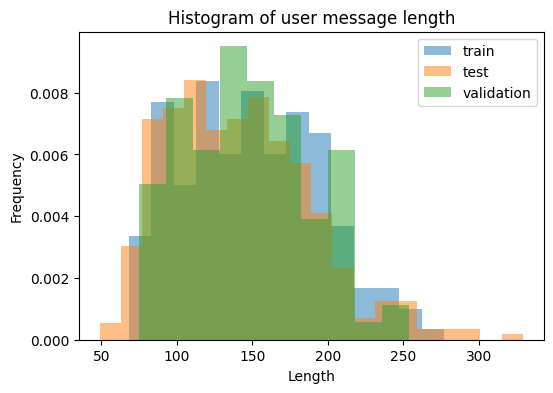

In [27]:
# plot a histogram of the size of user messages
fig, ax = plt.subplots(figsize=(6, 4))

for split, df in dfs.items():
    ax.hist(
        df["user_message"].apply(len),
        bins=int(np.sqrt(df.shape[0])),
        alpha=0.5,
        label=split,
        density=True,
    )

ax.legend()
ax.set_title("Histogram of user message length")
ax.set_xlabel("Length")
ax.set_ylabel("Frequency")
plt.show()

We visualize the distribution of function types

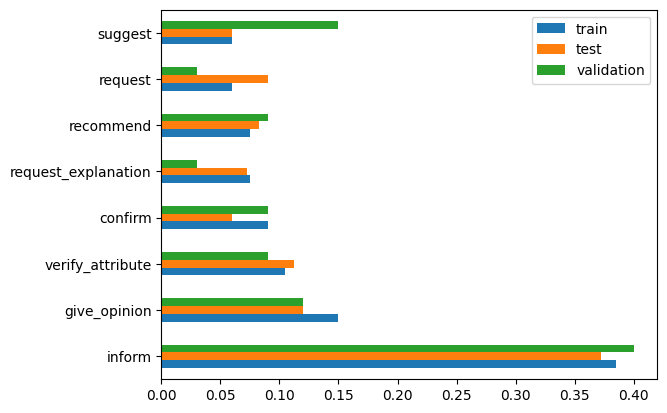

In [28]:
# Create a new DataFrame for the plot
plot_df = pd.DataFrame()

# Loop through each DataFrame in dfs
for idx, (split, df) in enumerate(dfs.items()):
    # Get the value counts and normalize
    value_counts = df["function_type"].value_counts(dropna=False, normalize=True)
    # Add the value counts to the plot DataFrame
    plot_df[split] = value_counts

# Plot the DataFrame as a grouped bar plot
plot_df.plot(kind='barh')

plt.legend()
plt.show()

Fairly consistant across datasets especially it seems that inform is the most prominent function type that we expect to see across datasets. If one of the function types is more important than the others, we might want to consider undersampling the other function types to balance the dataset.



Let us visualize the distribution of attribute types across the datasets.

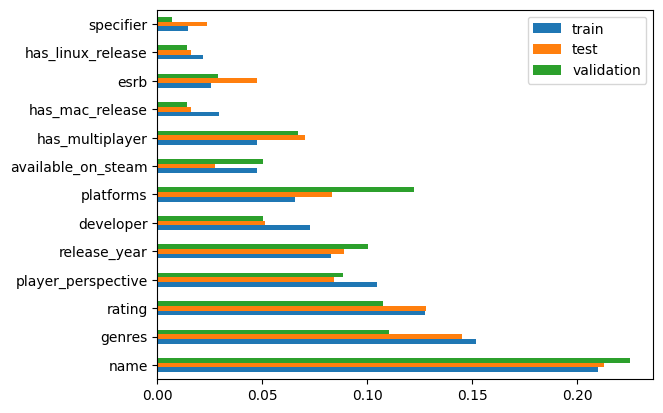

In [29]:
plot_df = pd.DataFrame()

# Loop through each DataFrame in dfs
for idx, (split, df) in enumerate(dfs.items()):
    # Get the value counts and normalize
    value_counts = df["attribute_types"].explode().value_counts(dropna=False, normalize=True)
    # Add the value counts to the plot DataFrame
    plot_df[split] = value_counts

# Plot the DataFrame as a grouped bar plot
plot_df.plot(kind='barh')

plt.legend()
plt.show()

## 2. Establishing a baseline performance evaluation

To establish a baseline performance evaluation, we will first:

1. Deploy a readily available LLM 
2. Build prompt-generation functions
3. Generate outputs from the LLM
4. Evaluate the performance on the task


### 1. Deploy a readily available LLM

To get start with a baseline, we will deploy a base model on the task. We will use the `mistralai/Mistral-7B-Instruct-v0.1` model for this task. This is an instruction finetuned version of the Mistral-7B model.

Note to do so we make use `ray-llm` and specifically pass the default Mistral-7B `ray-llm-config.yaml` configuration file.

In [30]:
service_name = "mistral-llm-dev"
config = ServiceConfig(
    name=service_name,
    working_dir=".",
    image_uri="localhost:5555/anyscale/endpoints_aica:0.5.0-5659",
    compute_config="default-serverless-config:1",
    applications=[
        {
            "name": "llm-endpoint",
            "route_prefix": "/",
            "import_path": "aviary_private_endpoints.backend.server.run:router_application",
            "args": {
                "models": [],
                "multiplex_models": ["ray-llm-config.yaml"],
                "dynamic_lora_loading_path": MODEL_STORAGE_PATH,
            },
            "runtime_env": {"env_vars": {"HUGGING_FACE_HUB_TOKEN": HUGGING_FACE_HUB_TOKEN}},
        }
    ],
)

config

ServiceConfig(name='mistral-llm-dev', image_uri='localhost:5555/anyscale/endpoints_aica:0.5.0-5659', compute_config='default-serverless-config:1')

In [31]:
deploy(config)

In [32]:
service_status = status(service_name)

while True:
    # Wait for the service to be deployed
    service_status = status(service_name)
    time.sleep(10)
    if service_status.state == ServiceState.RUNNING:
        break
    elif service_status.state in [
        ServiceState.UNHEALTHY,
        ServiceState.TERMINATED,
        ServiceState.SYSTEM_FAILURE,
    ]:
        raise RuntimeError(f"Service {service_name} failed.")
    elif service_status.state in [ServiceState.UNKNOWN]:
        print(f"Service {service_name} is in an unknown state.")


api_key = service_status.query_auth_token
base_url = service_status.query_url

### 2. Build prompt-generation functions

We will now build the prompt-generation functions that will be used to generate the inputs for the LLM.

The simplest is a zero-shot input where we make sure to use the same system prompt as we used in the training data.

In [33]:
def zero_shot(user_input: str) -> tuple[SystemMessageT, UserMessageT]:
    """Return a zero-shot completion of the user input."""
    return (
        {
            "role": "system",
            "content": SYSTEM_PROMPT,
        },
        {
            "role": "user",
            "content": user_input,
        },
    )

Lets inspect the `zero_shot` function

In [34]:
system_message, user_message = zero_shot(user_input=user0["content"])
pprint(system_message)
pprint(user_message)

{'content': 'Given a target sentence construct the underlying meaning '
            'representation\n'
            'of the input sentence as a single function with attributes and '
            'attribute\n'
            'values. This function should describe the target string '
            'accurately and the\n'
            "function must be one of the following ['inform', 'request', "
            "'give_opinion',\n"
            "'confirm', 'verify_attribute', 'suggest', 'request_explanation',\n"
            "'recommend', 'request_attribute'].\n"
            '\n'
            'The attributes must be one of the following:\n'
            "['name', 'exp_release_date', 'release_year', 'developer', 'esrb', "
            "'rating',\n"
            "'genres', 'player_perspective', 'has_multiplayer', 'platforms',\n"
            "'available_on_steam', 'has_linux_release', 'has_mac_release', "
            "'specifier']\n",
 'role': 'system'}
{'content': 'Here is the target sentence:\n'
            

It is very optimistic to expect readily available models to perform well on a task with zero-shot learning. Therefore, we will build a few-shot prompt generation function that will be used to generate the inputs for the LLM.

In [35]:
def few_shot(
    user_input: str,
    examples: list[
        tuple[
            SystemMessageT,
            UserMessageT,
            AssistantMessageT,
        ]
    ],
) -> tuple[SystemMessageT, UserMessageT]:
    """Build a prompt for few-shot learning given a user input and examples."""
    system_message, user_message = zero_shot(user_input)
    user_text = user_message["content"]

    example_preface = (
        "Examples are printed below."
        if len(examples) > 1
        else "An example is printed below."
    )
    example_preface += (
        ' Note: you are to respond with the string after "Output: " only.'
    )
    examples_parsed = "\n".join(
        [
            f"{user['content']}\nOutput: {assistant['content']}"
            for (system, user, assistant) in examples
        ]
    )
    response_preface = "Now please provide the output for:\n"
    user_text = f"{example_preface}\n{examples_parsed}\n{response_preface}\n{user_text}\nOutput: "
    return (system_message, {"role": "user", "content": user_text})

In [36]:
examples = [
    [
        system0,
        user0,
        assistant0,
    ],
    [
        system1,
        user1,
        assistant1
    ]
]

We inspect the `few_shot` function

In [37]:
messages = few_shot(
    user_input=user2["content"],
    examples=examples,
)
pprint(messages)

({'content': 'Given a target sentence construct the underlying meaning '
             'representation\n'
             'of the input sentence as a single function with attributes and '
             'attribute\n'
             'values. This function should describe the target string '
             'accurately and the\n'
             "function must be one of the following ['inform', 'request', "
             "'give_opinion',\n"
             "'confirm', 'verify_attribute', 'suggest', "
             "'request_explanation',\n"
             "'recommend', 'request_attribute'].\n"
             '\n'
             'The attributes must be one of the following:\n'
             "['name', 'exp_release_date', 'release_year', 'developer', "
             "'esrb', 'rating',\n"
             "'genres', 'player_perspective', 'has_multiplayer', 'platforms',\n"
             "'available_on_steam', 'has_linux_release', 'has_mac_release', "
             "'specifier']\n",
  'role': 'system'},
 {'content': 'Examples

To scale the input generation we put together, a function `parse_messages` that builds a user-input column and a ground-truth column from a batch of messages


In [38]:
def parse_messages(record: dict) -> dict:
    return {
        "user_input": extract_role(record["messages"], role="user"),
        "ground_truth": extract_role(record["messages"], role="assistant")
    }

Here is how you would use the function:

In [39]:
ray.data.from_pandas(dfs["train"]).map(parse_messages).to_pandas()

2024-06-06 03:45:03,811	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:03,812	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(parse_messages)]



,user_input,ground_truth
0,Here is the target sentence:\nDirt: Showdown f...,"inform(name[Dirt: Showdown], release_year[2012..."
1,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012..."
2,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012..."
3,Here is the target sentence:\nWere there even ...,"request(release_year[2014], specifier[terrible])"
4,Here is the target sentence:\nWhat's the most ...,"request(release_year[2014], specifier[terrible])"
...,...,...
195,Here is the target sentence:\nI've been having...,give_opinion(name[Age of Empires II: The Age o...
196,Here is the target sentence:\nI really liked A...,give_opinion(name[Age of Empires II: The Age o...
197,Here is the target sentence:\nAge of Empires I...,give_opinion(name[Age of Empires II: The Age o...
198,Here is the target sentence:\nSkyforge is a th...,"inform(name[Skyforge], release_year[2015], gen..."


We also put together a function `generate_inputs` that can then build out zero-shot and few-shot prompts for the user input.

In [40]:
def generate_inputs(
    record: dict,
    examples: list[list[SystemMessageT, UserMessageT, AssistantMessageT]],
) -> dict:
    if len(examples) == 0:
        sys, usr = zero_shot(record["user_input"])
    elif len(examples) >= 1:
        sys, usr = few_shot(
            user_input=record["user_input"],
            examples=examples,
        )
    record["model_input"] = usr["content"]
    return record

Here is how it would be added to our pipeline

In [41]:
(
    ray.data.from_pandas(dfs["train"])
    .map(parse_messages)
    .map(generate_inputs, fn_kwargs={"examples": examples})
    .to_pandas()
)

2024-06-06 03:45:07,434	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:07,434	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(parse_messages)->Map(generate_inputs)]



,user_input,ground_truth,model_input
0,Here is the target sentence:\nDirt: Showdown f...,"inform(name[Dirt: Showdown], release_year[2012...",Examples are printed below. Note: you are to r...
1,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012...",Examples are printed below. Note: you are to r...
2,Here is the target sentence:\nDirt: Showdown i...,"inform(name[Dirt: Showdown], release_year[2012...",Examples are printed below. Note: you are to r...
3,Here is the target sentence:\nWere there even ...,"request(release_year[2014], specifier[terrible])",Examples are printed below. Note: you are to r...
4,Here is the target sentence:\nWhat's the most ...,"request(release_year[2014], specifier[terrible])",Examples are printed below. Note: you are to r...
...,...,...,...
195,Here is the target sentence:\nI've been having...,give_opinion(name[Age of Empires II: The Age o...,Examples are printed below. Note: you are to r...
196,Here is the target sentence:\nI really liked A...,give_opinion(name[Age of Empires II: The Age o...,Examples are printed below. Note: you are to r...
197,Here is the target sentence:\nAge of Empires I...,give_opinion(name[Age of Empires II: The Age o...,Examples are printed below. Note: you are to r...
198,Here is the target sentence:\nSkyforge is a th...,"inform(name[Skyforge], release_year[2015], gen...",Examples are printed below. Note: you are to r...


### 3. Generate outputs from the LLM

Now that we have our prompt-generation functions, we will generate sample outputs from the LLM.

To do so, we make use of the openai SDK to interact with the model.

In [42]:
def build_client(base_url: str, api_key: str) -> openai.OpenAI:
    return openai.OpenAI(
        base_url=base_url.rstrip("/") + "/v1",
        api_key=api_key,
    )


def query(
    client: openai.OpenAI,
    llm_model: str,
    system_message: SystemMessageT,
    user_message: UserMessageT,
    temperature: float = 0,
    timeout: float = 3 * 60,
) -> Optional[str]:
    model_response = client.chat.completions.create(
        model=llm_model,
        messages=[system_message, user_message],
        temperature=temperature,
        timeout=timeout,
    )
    model_output = model_response.choices[0].message.content
    return model_output

We build the client

In [43]:
client = build_client(base_url=base_url, api_key=api_key)

Prepare the input and run a query

In [44]:
system_message, user_message = few_shot(
    user_input=user2["content"],
    examples=examples,
)

query(
    client=client,
    llm_model=LLM_MODEL,
    system_message=system_message,
    user_message=user_message,
)

' inform(name[Dirt: Showdown], release_year[2012], esrb[E 10+], genres[driving/racing, sport], platforms[PlayStation, Xbox, PC], available_on_steam[no], has_linux_release[no], has_mac_release[no])'

Lets compare it with the ground truth

In [45]:
assistant2["content"]

'inform(name[Dirt: Showdown], release_year[2012], esrb[E 10+ (for Everyone 10 and Older)], genres[driving/racing, sport], platforms[PlayStation, Xbox, PC], available_on_steam[no], has_linux_release[no], has_mac_release[no])'

Let's confirm that indeed zero-shot learning is not sufficient for this task by querying the model with a zero-shot prompt.

In [46]:
# Generate a zero-shot prompt
system_message, user_message = zero_shot(user2["content"])

# Run the query
query(
    client=client,
    llm_model=LLM_MODEL,
    system_message=system_message,
    user_message=user_message
)

' The underlying meaning representation of the input sentence as a single function with attributes and attribute values is:\n\nfunction: request_attribute\nattributes:\n- name: Dirt: Showdown\n- exp_release_date: 2012\n- rating: E 10+\n- platforms: PlayStation, Xbox, PC\n- available_on_steam: False\n- has_linux_release: False\n- has_mac_release: False'

To scale the generation of the prompts we will declare a callable class `ModelClient` which we can apply using ray data's `map` function.

In [47]:
class ModelClient:
    def __init__(self, base_url: str = base_url, api_key: str = api_key) -> None:
        self.client = build_client(base_url, api_key)

    def __call__(
        self,
        record: dict,
        llm_model: str = LLM_MODEL,
    ) -> dict:
        try:
            record["model_output"] = query(
                client=self.client,
                llm_model=llm_model,
                system_message={"role": "system", "content": SYSTEM_PROMPT},
                user_message={"role": "user", "content": record["model_input"]}
            )

        except Exception as e:
            record["model_output"] = np.nan
            record["model_failure"] = str(e)

        else:
            record["model_failure"] = np.nan 
        
        return record

In [48]:
(
    ray.data.from_pandas(dfs["train"])
    .limit(1)
    .map(parse_messages)
    .map(generate_inputs, fn_kwargs={"examples": examples})
    .map(ModelClient, concurrency=1)
    .to_pandas()
)

2024-06-06 03:45:17,825	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:17,825	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1] -> ActorPoolMapOperator[Map(parse_messages)->Map(generate_inputs)->Map(ModelClient)]



,user_input,ground_truth,model_input,model_output,model_failure
0,Here is the target sentence:\nDirt: Showdown f...,"inform(name[Dirt: Showdown], release_year[2012...",Examples are printed below. Note: you are to r...,"inform(name[Dirt: Showdown], release_year[201...",NaN


We will now generate outputs given an increasing number of few-shot examples.

In [51]:
df_outputs = {}
n_few_shot = [0, 1, 3, 5, 10, 20]
max_concurrency = 64

def gen_outputs(record):
    n = record["n"]
    dest = f"/mnt/cluster_storage/outputs/dev/{n}_few_shot_sampled.json"
    if os.path.exists(dest):
        shutil.rmtree(dest)

    examples = dfs["train"].sample(n)["messages"].tolist()
    assert len(examples) == n
    
    (
        ray.data.from_pandas(dfs["test"])
        .repartition(max_concurrency)
        .map(parse_messages, num_cpus=0.01)
        .map(generate_inputs, fn_kwargs={"examples": examples}, num_cpus=0.01)
        .map(ModelClient, concurrency=max_concurrency, num_cpus=0.01)
        .write_json(dest)
    )
    return record

ray.data.from_items([{"n": n} for n in n_few_shot]).map(gen_outputs).materialize()

In [52]:
df_outputs = {}
for n in n_few_shot:
    # TODO - change to shared_storage so it is accessible org-wide
    src = f"/mnt/cluster_storage/outputs_{n}_few_shot_sampled.json"
    df_outputs[n] = ray.data.read_json(src).to_pandas()

### 4. Evaluate the performance on the task

Lets post process the outputs to extract the ground-truth vs model predicted function types and attriute types

In [53]:
def post_process(record: dict):
    record.update(
        {
            "ground_truth_fn_type": extract_function_type(record["ground_truth"]),
            "ground_truth_attr_types": extract_attribute_types(record["ground_truth"]),
            "model_fn_type": extract_function_type(record["model_output"]),
            "model_attr_types": extract_attribute_types(record["model_output"]),
    }
    )
    return record

In [54]:
ray.data.from_pandas(df_outputs[5]).map(post_process).take(1)

2024-06-06 03:45:49,097	INFO dataset.py:2368 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-06-06 03:45:49,099	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:49,100	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(post_process)] -> LimitOperator[limit=1]



[{'user_input': "Here is the target sentence:\nI'm looking for something to make me laugh, what do you think is the funniest game you've ever played?",
  'ground_truth': 'request(specifier[funniest])',
  'model_input': 'Examples are printed below. Note: you are to respond with the string after "Output: " only.\nHere is the target sentence:\nSuper Bomberman is an action and strategy game from 1993 for Nintendo consoles and PC only. It\'s an older console game that is, unfortunately, not available to play on Steam and does not offer support for Mac or Linux.\nOutput: inform(name[Super Bomberman], release_year[1993], genres[action, strategy], platforms[Nintendo, PC], available_on_steam[no], has_linux_release[no], has_mac_release[no])\nHere is the target sentence:\nWhy is it that you like to play bird view perspective hack-and-slash RPGs?\nOutput: request_explanation(rating[good], genres[hack-and-slash, role-playing], player_perspective[bird view])\nHere is the target sentence:\nFireproof 

We start by excluding any failed responses

In [55]:
def exclude_failed_responses(batch: dict[str, pd.Series]) -> dict[str, pd.Series]:
    failed_responses = batch["model_failure"].notnull()
    return {
        k: v[~failed_responses]
        for k, v in batch.items()
    }


In [56]:
ray.data.from_pandas(df_outputs[10]).map_batches(exclude_failed_responses, batch_format="pandas").take(1)

2024-06-06 03:45:52,681	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:52,681	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)] -> LimitOperator[limit=1]



[{'user_input': "Here is the target sentence:\nBlizzard Entertainment's StarCraft is a very good RTS, for real.",
  'ground_truth': 'give_opinion(name[StarCraft], developer[Blizzard Entertainment], rating[good], genres[real-time strategy])',
  'model_input': 'Examples are printed below. Note: you are to respond with the string after "Output: " only.\nHere is the target sentence:\nLayers of Fear, the indie first person point-and-click adventure game?\nOutput: confirm(name[Layers of Fear], genres[adventure, indie, point-and-click], player_perspective[first person])\nHere is the target sentence:\nThe Forest of Doom is an average 2014 text adventure RPG. It\'s for PC only and available on Steam. There\'s Linux and Mac support too.\nOutput: inform(name[The Forest of Doom], release_year[2014], rating[average], genres[role-playing, text adventure], platforms[PC], available_on_steam[yes], has_linux_release[yes], has_mac_release[yes])\nHere is the target sentence:\nDirt: Showdown is a multiplay

We then compute the accuracy of the predicting the function type

In [57]:
def check_function_type_accuracy(batch: dict) -> dict:
    batch["fn_type_match"] = batch["ground_truth_fn_type"] == batch["model_fn_type"]
    return batch

2024-06-06 03:45:54,956	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:54,957	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy) pid=9723, ip=100.98.23.21) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'model_failure', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy) pid=9723, ip=100.98.23.21) - Expand out each key-value pair in the dict column into its own column
(MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy) pid=9723, ip=100.98.23.21) - Replace `None` values with an Arrow supported data type
(MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type

few-shot n=0 function type accuracy: 0.0


2024-06-06 03:45:57,494	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:57,494	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=1 function type accuracy: 0.245


2024-06-06 03:45:58,723	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:58,723	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=3 function type accuracy: 0.505


2024-06-06 03:45:59,962	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:45:59,963	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=5 function type accuracy: 0.535


2024-06-06 03:46:01,220	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:01,221	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=10 function type accuracy: 0.52


2024-06-06 03:46:02,498	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:02,499	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=20 function type accuracy: 0.4875


Text(0, 0.5, 'Accuracy')

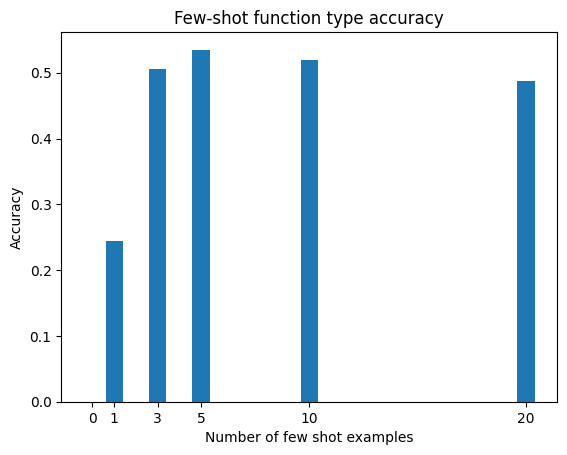

In [58]:
fn_type_accuracy = []
for n in n_few_shot:
    output = (
        ray.data.from_pandas(df_outputs[n])
        .map_batches(exclude_failed_responses, batch_format="pandas")
        .map(post_process)
        .map_batches(check_function_type_accuracy)
        .mean(on="fn_type_match")
    )
    print(f"few-shot n={n} function type accuracy: {output}")
    fn_type_accuracy.append(output)

plt.bar(n_few_shot, fn_type_accuracy)
plt.title("Few-shot function type accuracy")
plt.xlabel("Number of few shot examples")
plt.xticks(n_few_shot)
plt.ylabel("Accuracy")

The function type accuracy is the highest when using 5 examples at 53.5%. Further examples do not seem to improve the accuracy but instead decrease it perhaps due to the model overfitting to the context.

In [59]:
def check_attribute_types_accuracy(batch: dict) -> dict:
    batch["attr_types_match"] = batch["ground_truth_attr_types"].apply(set) == batch["model_attr_types"].apply(set)
    return batch

Let's compute the accuracy of predicting the attribute types.

2024-06-06 03:46:09,012	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:09,013	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=0 function type accuracy: 0.0


2024-06-06 03:46:10,260	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:10,261	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=1 function type accuracy: 0.045


2024-06-06 03:46:11,499	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:11,500	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=3 function type accuracy: 0.18


2024-06-06 03:46:12,750	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:12,751	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=5 function type accuracy: 0.2525


2024-06-06 03:46:14,026	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:14,026	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=10 function type accuracy: 0.27


2024-06-06 03:46:15,316	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 03:46:15,317	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(exclude_failed_responses)->Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/1 [00:00<?, ?it/s]

few-shot n=20 function type accuracy: 0.2175


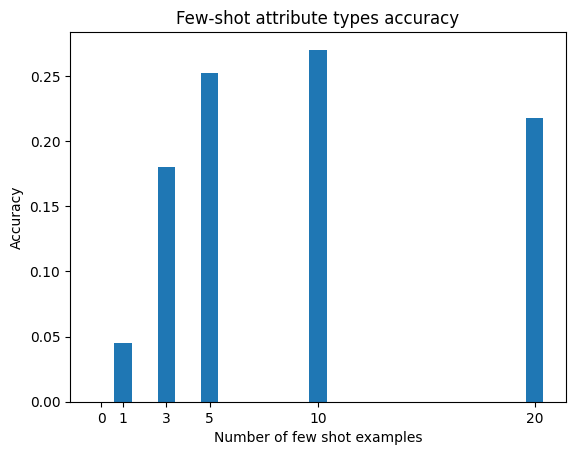

In [60]:
attr_types_accuracy = []
for n in n_few_shot:
    output = (
        ray.data.from_pandas(df_outputs[n])
        .map_batches(exclude_failed_responses, batch_format="pandas")
        .map(post_process)
        .map_batches(check_attribute_types_accuracy, batch_format="pandas")
        .mean(on="attr_types_match")                     
    )
    print(f"few-shot n={n} function type accuracy: {output}")
    attr_types_accuracy.append(output)

plt.bar(n_few_shot, attr_types_accuracy)
plt.title("Few-shot attribute types accuracy")
plt.xlabel("Number of few shot examples")
plt.xticks(n_few_shot)
plt.ylabel("Accuracy")
plt.show()

We can look at more granular metrics like the confusion matrix, recall and precision for each function type. But for our evaluation purposes we will stop here and call this our baseline performance evaluation. 

For instance, naively always predicting inform as the function type will yield an accuracy of around 40%, so we can see that the model is learning from the examples. 

## 3. Finetune an LLM

Let's see if we can improve on our baseline by finetuning a model. 

In [61]:
with open("./finetune/config.yaml", "r") as f:
    finetune_config = yaml.safe_load(f)

Anyscale's llm-forge's finetune config can be split into the following:

- Data config
    - `train_path`: The path to the training data.
    - `valid_path`: The path to the validation data.
    - `context_length`: The maximum number of tokens in the input.
- Model config:
    - `model_id`: The hugingface model name.
- LoRA config:
    - `lora_config`: The LoRA configuration, here are the key parameters:
        - `r`: The rank of the LoRA matrix.
        - `target_modules`: Which modules to apply LoRA to.
        - `lora_alpha`: The LoRA alpha parameter (a scaling factor).
- Training config:
    - `learning_rate`: The learning rate for the optimizer.
    - `num_epochs`: The number of epochs to train for.
    - `train_batch_size_per_device`: The batch size per device for training.
    - `eval_batch_size_per_device`: The evaluation batch size per device.
    - `num_devices`: The number of devices to train on.
    - `worker_resources`: The accelerator type to use.
- Output config
    - `num_checkpoints_to_keep`: The number of checkpoints to keep.
    - `output_dir`: The output directory for the model.
- Advanced training config
    - `deepspeed`: Settings for distributed training strategy like FSDP (fully sharded data parallel)
        - this can enclude specifying the stage of `FSDP`
        - whether to make use of CPU offloading for parameter and optimizer states.

Default configurations for all the popular models are available in the `llm-forge` library and are a good starting point for most tasks.

In [62]:
unique_id = str(uuid4())[:4]
model_id = f"mistralai/Mistral-7B-Instruct-v0.1:{unique_id}:viggo-subset-200"
model_id

'mistralai/Mistral-7B-Instruct-v0.1:7d5d:viggo-subset-200'

We make use of `llmforge` an anyscale library to perform our finetuning. Here is how we would use it:

```bash
llmforge dev finetune "finetune/config.yaml" --model-tag={model_id} --forward-best-checkpoint-remote-uri={model_storage_path}
```

- The `finetune/config.yaml` file contains the configuration for the finetuning task.
    - The configuration file contains the lora, dataset, and training parameters.
- The `model_id` is the tag we want to give to the model we are finetuning.
    - this is what we will use to refer to the model when making requests to our server using the openai SDK
- The `forward-best-checkpoint-remote-uri` is the path where we want to store the model.
    - this path needs to match where our server is looking for models to serve




In [63]:
!llmforge dev finetune "finetune/config.yaml" --model-tag={model_id} --forward-best-checkpoint-remote-uri={MODEL_STORAGE_PATH}  >> log_file 2>&1

(autoscaler +3m3s) [autoscaler] [4xA10G:48CPU-192GB] Upscaling 1 node(s).
(autoscaler +3m4s) [autoscaler] [4xA10G:48CPU-192GB|g5.12xlarge] [us-east-2a] [on-demand] Launched 1 instances.
(autoscaler +4m28s) [autoscaler] Downscaling node i-0de777966564ff4ad (node IP: 100.72.217.71) due to node idle termination.
(autoscaler +4m28s) [autoscaler] Downscaling node i-0d29815f55c87cc09 (node IP: 100.74.253.34) due to node idle termination.
(autoscaler +4m28s) [autoscaler] Downscaling node i-082214f2a09fe6701 (node IP: 100.98.23.21) due to node idle termination.
(autoscaler +4m28s) [autoscaler] Downscaling node i-0de5d21d04d4406e6 (node IP: 100.65.224.46) due to node idle termination.
(autoscaler +7m3s) [autoscaler] [8CPU-32GB] Upscaling 2 node(s).
(autoscaler +7m5s) [autoscaler] [8CPU-32GB|m5.2xlarge] [us-east-2a] [on-demand] Launched 2 instances.
(autoscaler +8m46s) [autoscaler] Cluster upscaled to {56 CPU, 4 GPU}.
(autoscaler +8m52s) [autoscaler] Cluster upscaled to {64 CPU, 4 GPU}.
(autosca

We can inspect the produced model files

In [64]:
!aws s3 ls {MODEL_STORAGE_PATH}{model_id}/

2024-06-06 04:03:52         93 README.md
2024-06-06 04:03:52        617 adapter_config.json
2024-06-06 04:03:52   43158152 adapter_model.safetensors
2024-06-06 04:03:53        704 config.json
2024-06-06 04:03:53         16 new_embeddings.safetensors
2024-06-06 04:03:53        437 special_tokens_map.json
2024-06-06 04:03:53    1795554 tokenizer.json
2024-06-06 04:03:53     493443 tokenizer.model
2024-06-06 04:03:53       1468 tokenizer_config.json


## 4. Evaluate the Finetuned LLM

In [67]:
(
    ray.data.from_pandas(dfs["test"])
    .limit(1)
    .repartition(1)
    .map(parse_messages, num_cpus=0.01)
    .map(generate_inputs, fn_kwargs={"examples": []}, num_cpus=0.01)
    .map(ModelClient, concurrency=1, fn_kwargs={"llm_model": model_id}, num_cpus=0.01)
    .to_pandas()
)

2024-06-06 04:06:30,653	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 04:06:30,654	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1] -> AllToAllOperator[Repartition] -> ActorPoolMapOperator[Map(parse_messages)->Map(generate_inputs)->Map(ModelClient)]



- Repartition 1:   0%|          | 0/1 [00:00<?, ?it/s]

,user_input,ground_truth,model_input,model_output,model_failure
0,Here is the target sentence:\nRise of the Tomb...,"inform(name[Rise of the Tomb Raider], genres[a...",Here is the target sentence:\nRise of the Tomb...,"inform(name[Rise of the Tomb Raider], genres[a...",NaN


In [69]:
max_concurrency = 32

dest_outputs_finetune = "/mnt/cluster_storage/dev/outputs_fine_tuned.json"
if os.path.exists(dest_outputs_finetune):
    shutil.rmtree(dest_outputs_finetune)
     
(
    ray.data.from_pandas(dfs["test"])
    .repartition(max_concurrency)
    .map(parse_messages, num_cpus=0.01)
    .map(generate_inputs, fn_kwargs={"examples": []}, num_cpus=0.01)
    .map(ModelClient, concurrency=max_concurrency, fn_kwargs={"llm_model": model_id}, num_cpus=0.01)
    .write_json(dest_outputs_finetune)
)

2024-06-06 04:17:14,398	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 04:17:14,398	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> ActorPoolMapOperator[Map(parse_messages)->Map(generate_inputs)->Map(ModelClient)] -> TaskPoolMapOperator[Write]



- Repartition 1:   0%|          | 0/32 [00:00<?, ?it/s]

2024-06-06 04:26:55,772	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 04:26:55,773	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadJSON] -> TaskPoolMapOperator[Map(post_process)->MapBatches(check_function_type_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/32 [00:00<?, ?it/s]

(Map(post_process)->MapBatches(check_function_type_accuracy) pid=16396, ip=100.88.235.81) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'model_failure', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(Map(post_process)->MapBatches(check_function_type_accuracy) pid=16396, ip=100.88.235.81) - Expand out each key-value pair in the dict column into its own column
(Map(post_process)->MapBatches(check_function_type_accuracy) pid=16396, ip=100.88.235.81) - Replace `None` values with an Arrow supported data type
(Map(post_process)->MapBatches(check_function_type_accuracy) pid=16396, ip=100.88.235.81) 


finetune function type accuracy: 0.8475


<Axes: title={'center': 'Function type accuracy'}, xlabel='Method', ylabel='Accuracy'>

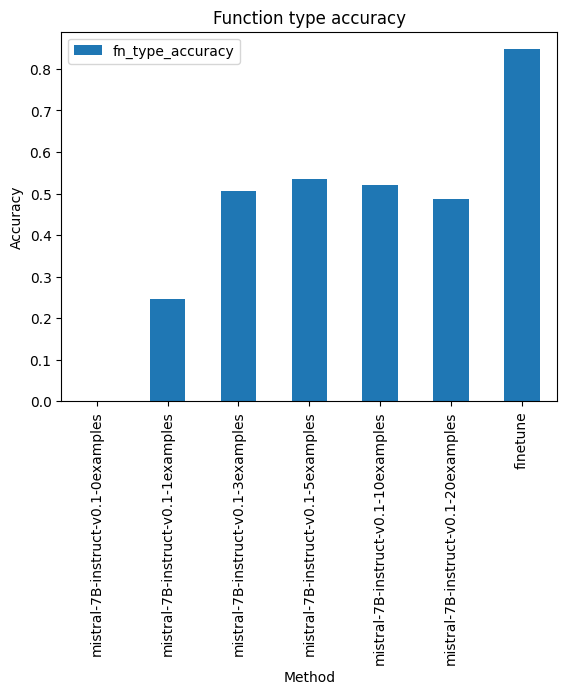

In [70]:
finetune_fn_accuracy = (
    ray.data.read_json(dest_outputs_finetune)
    .map(post_process)
    .map_batches(check_function_type_accuracy)
    .mean(on="fn_type_match")
)

print(f"finetune function type accuracy: {finetune_fn_accuracy}")

pd.DataFrame(
    {
        "model": [f"mistral-7B-instruct-v0.1-{n}examples" for n in n_few_shot]
        + ["finetune"],
        "fn_type_accuracy": fn_type_accuracy + [finetune_fn_accuracy],
    }
).plot(
    kind="bar",
    x="model",
    y="fn_type_accuracy",
    title="Function type accuracy",
    ylabel="Accuracy",
    xlabel="Method",
)

2024-06-06 04:26:59,322	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-06_02-59-32_685230_5556/logs/ray-data.log
2024-06-06 04:26:59,323	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadJSON] -> TaskPoolMapOperator[Map(post_process)->MapBatches(check_attribute_types_accuracy)] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]



- Aggregate 1:   0%|          | 0/32 [00:00<?, ?it/s]

finetune attribute types accuracy: 0.5025


<Axes: title={'center': 'Attribute types accuracy'}, xlabel='Method', ylabel='Accuracy'>

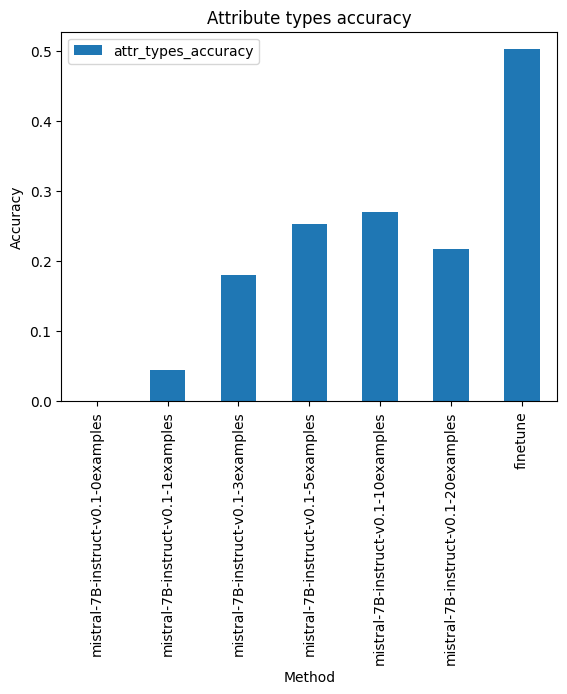

In [71]:
finetune_attr_types_accuracy = (
    ray.data.read_json(dest_outputs_finetune)
    .map(post_process)
    .map_batches(check_attribute_types_accuracy, batch_format="pandas")
    .mean(on="attr_types_match")
)

print(f"finetune attribute types accuracy: {finetune_attr_types_accuracy}")

pd.DataFrame(
    {
        "model": [f"mistral-7B-instruct-v0.1-{n}examples" for n in n_few_shot]
        + ["finetune"],
        "attr_types_accuracy": attr_types_accuracy + [finetune_attr_types_accuracy],
    }
).plot(
    kind="bar",
    x="model",
    y="attr_types_accuracy",
    title="Attribute types accuracy",
    ylabel="Accuracy",
    xlabel="Method",
)